In [2]:
import pandas as pd
import numpy as np
import random
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
import umap
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
artists_df = pd.read_table('hetrec2011-lastfm-2k/artists.dat')
artists_df = artists_df.loc[:, ['id', 'name']]

def get_artist_by_id(artist_id):
    return artists_df.loc[artists_df['id'] == artist_id]['name'].values[0]


In [4]:
get_artist_by_id(288)

'Rihanna'

In [5]:
artists_df.sample(n=10)

,id,name
9906,10171,Uniform
14634,15382,Afro Kolektyw
5088,5207,Rooster
73,79,Fiction Factory
3594,3666,The Hold Steady
15293,16091,Marie & Nick
142,148,The Boats
7297,7453,Eliana
4139,4223,The Spill Canvas
13832,14471,"Ricky Gervais, Steve Merchant & Karl Pilkington"


In [6]:
user_artists_df = pd.read_table('hetrec2011-lastfm-2k/user_artists.dat')
user_artists_df = user_artists_df.loc[:, ['userID', 'artistID']]
user_artists_df

,userID,artistID
0,2,51
1,2,52
2,2,53
3,2,54
4,2,55
...,...,...
92829,2100,18726
92830,2100,18727
92831,2100,18728
92832,2100,18729


In [7]:
#create a test set and remove 20% of the users
unique_users = np.unique(user_artists_df.iloc[:,0])
test_users = random.choices(unique_users, k=int(0.2 * len(unique_users)))
train_data = user_artists_df[~user_artists_df['userID'].isin(test_users)]

In [8]:
user_enc = LabelEncoder()
item_enc = LabelEncoder()

encoded_users = user_enc.fit_transform(train_data.iloc[:,0])
encoded_items = item_enc.fit_transform(train_data.iloc[:,1])

In [9]:
len(np.unique(encoded_users))

1554

In [10]:
%%time

# Calculate the EASE matrix
values = np.ones(train_data.shape[0])

l = 0.5
X = csr_matrix((values, (encoded_users, encoded_items)))
G = X.T.dot(X).toarray()

diag_indices = np.diag_indices(G.shape[0])

G[diag_indices] += l

P = np.linalg.inv(G)
B = P / (-np.diag(P))

B[diag_indices] = 0

mat_user_items = X.dot(B)

CPU times: user 5min 40s, sys: 12.7 s, total: 5min 52s
Wall time: 1min 13s


In [11]:
print(f'We have {len(np.unique(encoded_users))} users and {len(np.unique(encoded_items))} Items')

We have 1554 users and 15561 Items


In [15]:
P.shape

(15561, 15561)

In [25]:
G[0][0:5]

array([2.5, 0. , 0. , 0. , 0. ])

In [26]:
P[0][0:5]

array([ 1.87650264e+00, -4.32669629e-04,  8.33859806e-04,  1.04941400e-03,
        4.42131793e-04])

### an example of how we can use the item in order to find the users

In [18]:
artist_id = np.random.choice(encoded_items)
print('artist id: ', artist_id)
print('actual artist ', item_enc.inverse_transform([artist_id]))
print(get_artist_by_id(item_enc.inverse_transform([artist_id])[0]))

artist id:  566
actual artist  [612]
Talking Heads


In [19]:
#nearby users
n_neig = 250
closest = np.argpartition(mat_user_items.T[artist_id], -n_neig)[-n_neig:]
#nearby users real ids
closest_real_id = user_enc.inverse_transform(closest)

In [20]:
# get the top artists that they hear
top_artists = user_artists_df.loc[user_artists_df['userID']
    .isin(closest_real_id)]\
    .groupby(['artistID'])\
    .count()\
    .sort_values(by='userID', ascending=False)[:10].index

[get_artist_by_id(aid) for aid in top_artists]

['The Beatles',
 'Radiohead',
 'David Bowie',
 'Depeche Mode',
 'The Cure',
 'Lady Gaga',
 'The Smiths',
 'Muse',
 'The Killers',
 'Kings of Leon']

In [21]:
scores = []
unique_users = np.unique(encoded_users)
for ix in range(5000):
    rand_user = random.choice(unique_users)
    # print(rand_user)
    #'Top 10 to recemmended'
    fav = np.argpartition(mat_user_items[rand_user], -10)[-10:]
    recs = [item_enc.inverse_transform([item_id])[0] for item_id in fav]
    # print (recs)
    # actual views
    # print('User actual views')
    hh = user_enc.inverse_transform([rand_user])
    views = train_data.loc[train_data['userID'] == hh[0]]['artistID'].values
    # print(views)
    intersecting = len(set(views).intersection(recs))
    # print(intersecting)
    scores.append(intersecting)
    
print(f'mean score:{np.mean(scores)} || median score:{np.median(scores)}')

mean score:9.9382 || median score:10.0


In [22]:
pca = PCA(n_components=50)
pca_reduced = pca.fit_transform(mat_user_items)

In [ ]:
%%time
import umap

umap_m = umap.UMAP(
    n_neighbors=20,
    min_dist=0.2,
    n_components=10)

umap_reduced = umap_m.fit_transform(pca_reduced)

In [ ]:
# GMM clustering
gmm_model = GMM(12, covariance_type='full', random_state=0, n_init=10)
gmm_labels = gmm_model.fit_predict(umap_reduced)
centers = gmm_model.means_

In [ ]:
vis_emb = umap.UMAP(
        n_neighbors=20,
        min_dist=0.2,
        n_components=2).fit_transform(pca_reduced)

fig = plt.figure(figsize=(14,10))
plt.scatter(vis_emb[:, 0], vis_emb[:, 1], c=gmm_labels, cmap='tab20c')

viz_clusters = pd.DataFrame(vis_emb)
viz_clusters['cluster'] = gmm_labels
print(viz_clusters['cluster'].value_counts())

for row in viz_clusters.groupby('cluster').mean().reset_index().values:
    label = f'CLUSTER: {row[0]}'
    plt.annotate(label, (row[1], row[2]), textcoords="offset points", fontsize=12,  xytext=(25,0), ha='center') 

In [7]:
grp_users = user_artists_df.groupby(['userID']).indices

In [ ]:
user_items_arr = X.A # just the user X items matrix

In [ ]:
clusters_views = {}
for user_id, label in tqdm(enumerate(gmm_labels)):
    items_ids = np.where(user_items_arr[user_id] == 1)[0]
    if label not in clusters_views:
        clusters_views[label] = {}
    items_names = [get_artist_by_id(aid) for aid in item_enc.inverse_transform(items_ids)]
    for item_name in items_names:
        if item_name not in clusters_views[label]:
            clusters_views[label][item_name] = 0
        clusters_views[label][item_name] += 1

In [ ]:
import operator

def print_list(l):
    for i in l:
        print(i)
    print('\n')
    
for cluster in clusters_views.keys():
    print(f'cluster: {cluster}')
    top_items = list(sorted(clusters_views[cluster].items(),
                            key=operator.itemgetter(1), reverse=True))[:15]
    print_list(top_items)

In [9]:
grp_users = user_artists_df.groupby(['userID']).indices 

In [10]:
%%time
# user name => artists
text_parts = {}
for user in grp_users:
    artist_ix = np.array(grp_users[user])
    artists = user_artists_df.iloc[artist_ix]
    text_parts[user] = list(artists['artistID'].values)

# list of user names || the ID in the list maps to name
user_keys = list(text_parts.keys())

CPU times: user 319 ms, sys: 23.5 ms, total: 343 ms
Wall time: 325 ms


In [ ]:
from gensim.models import Word2Vec

vec_size = 36
word_window = 128

### Word2Vec
w2v_model = Word2Vec(text_parts.values(), min_count=3, vector_size=vec_size, workers=12, window=word_window, sg=1, ns_exponent=-0.5)

In [ ]:
%%time
#create the matrix to hold the users means
user_embedding = np.zeros(shape=(len(user_keys),vec_size))
for ix, user in enumerate(user_keys):
    hh_progs = [prog for prog in text_parts[user] if w2v_model.wv.has_index_for(prog)]
    if len(hh_progs) == 0:
        print(f'user:{user} has no programs')
    else:
        hh_mean = np.mean(w2v_model.wv[hh_progs], axis=0)
        user_embedding[ix] = hh_mean

In [127]:
from scipy.spatial import distance

def cos_dist_from_mat(matrix, vector):
    v = vector.reshape(1, -1)
    return distance.cdist(matrix, v, 'cosine').reshape(-1)


def get_nearby_vectors_ids(vector, matrix, n_items=20):
    sim_score = 1 - cos_dist_from_mat(matrix, vector)
    return sim_score.argsort()[-n_items:][::-1]

def print_list(l):
    for i in l:
        print(i)
    print('\n')

In [ ]:
scores = []

for test_user in tqdm(test_users):
    #print('test_user: ', test_user)
    #its embedding id => we need to find the array position based on the DF name
    test_user_emb_id = (
        lambda x: np.where(np.array(user_keys) == x)
    )(test_user)[0][0]
    #print('test_user_emb_id: ', test_user_emb_id)
    
    test_user_mean = user_embedding[test_user_emb_id]
    #print('test_user_mean: ', test_user_mean)

    # find the similar 
    nearby_users_ids = get_nearby_vectors_ids(test_user_mean, user_embedding, n_items=20)
    nearby_users_keys = np.array(user_keys)[nearby_users_ids]
    
    most_pop_artists = user_artists_df\
        .loc[user_artists_df['userID'].isin(nearby_users_keys)]\
        .groupby('artistID')['userID']\
        .count().sort_values(ascending=False)[:10].index
    
    rec = [get_artist_by_id(aid) for aid in np.array(most_pop_artists)]
    
    # actual views
    user_pops = user_artists_df\
        .loc[user_artists_df['userID'] == test_user]['artistID'].values
    actual = [get_artist_by_id(aid) for aid in user_pops]
    
    score = len(set(rec).intersection(actual))
    scores.append(score)

In [ ]:
print(f'mean score:{np.mean(scores)} || median score:{np.median(scores)}')

In [ ]:
np.argsort([0.5, 0.9,0.2])[-1:]

In [ ]:
# find what is reccomended according to clusters
scores = []

for test_user in tqdm(test_users):
    
    test_user_emb_id = (
        lambda x: np.where(np.array(user_keys) == x)
    )(test_user)[0][0]
    
    # Get the user embedding in order to find those who are close to him
    test_user_mean = user_embedding[test_user_emb_id]
 
    # find N that are closest to him
    # find N-neaerst users in the W2V embedding - we can create a vector for a user that was not seen by the model
    n_users = 30
    nearby_users_ids = get_nearby_vectors_ids(test_user_mean, user_embedding, n_items=n_users)
    # find the keys/labels for these users to find them in the learned clusters above
    nearby_users_keys = np.array(user_keys)[nearby_users_ids]
    
    # get the ids from the keys/labels
    ids = [user_enc.transform([key])[0] for key in list(nearby_users_keys) if key not in test_users]
    # for each user get the distance to each cluster
    probs = gmm_model.predict_proba(umap_reduced[ids])
    # get the mean for the group => the mean distance of the group to each clutser
    # get the 3 closest clusters
    top_prob_cls = np.argsort(np.mean(probs, axis=0))[-2:]
    recs = []
    # get the 10 programs that are most popular in these clusters
    for cluster in top_prob_cls:
        top_cluster_items = list(sorted(clusters_views[cluster].items(),
                            key=operator.itemgetter(1), reverse=True))[:5]
        recs.extend(top_cluster_items)
        
    recs = [content[0] for content in recs]
    #print_list(np.unique(recs))
    
    # actual views
    user_pops = user_artists_df\
        .loc[user_artists_df['userID'] == test_user]['artistID'].values
    actual = [get_artist_by_id(aid) for aid in user_pops]
    
    #print('\nActual:')
    #print_list(actual)
    #print (set(recs).intersection(actual))
    score = len(set(recs).intersection(actual))
    scores.append(score)

print(f'mean score:{np.mean(scores)} || median score:{np.median(scores)}')

In [ ]:
# find what is reccomended for the users that surround him

scores = []

for test_user in tqdm(test_users):
    
    test_user_emb_id = (
        lambda x: np.where(np.array(user_keys) == x)
    )(test_user)[0][0]
 
    test_user_mean = user_embedding[test_user_emb_id]
 
    # find the similar 
    nearby_users_ids = get_nearby_vectors_ids(test_user_mean, user_embedding, n_items=10)
    nearby_users_keys = np.array(user_keys)[nearby_users_ids]

    ids = [user_enc.transform([key])[0] for key in list(nearby_users_keys) if key not in test_users]
    
    recs = []
    for _id in ids:
        fav = np.argpartition(mat_user_items[_id], -10)[-15:]
        recs = [item_enc.inverse_transform([item_id])[0] for item_id in fav]
        #print('rec:', _id)
        #print([get_artist_by_id(aid) for aid in recs])
        recs.extend(recs)
   
    (unique, counts) = np.unique(recs, return_counts=True)
    pop_cls = np.argsort(counts)[-15:]
    pop_cls_keys = unique[pop_cls]
    recs =  [get_artist_by_id(aid) for aid in pop_cls_keys]
    #print(recs)
    
    # actual views
    user_pops = user_artists_df\
        .loc[user_artists_df['userID'] == test_user]['artistID'].values
    actual = [get_artist_by_id(aid) for aid in user_pops]
    
    score = len(set(recs).intersection(actual))
    scores.append(score)

In [ ]:
print(f'mean score:{np.mean(scores)} || median score:{np.median(scores)}')

In [ ]:
np.argpartition(mat_user_items[_id], -10)[-10:]

In [ ]:
most_pop_artists = user_artists_df\
        .loc[user_artists_df['userID'].isin(nearby_users_keys)]\
        .groupby('artistID')['userID']\
        .count().sort_values(ascending=False)[:10].index
    
    rec = [get_artist_by_id(aid) for aid in np.array(most_pop_artists)]
    
    # actual views
    user_pops = user_artists_df\
        .loc[user_artists_df['userID'] == test_user]['artistID'].values
    actual = [get_artist_by_id(aid) for aid in user_pops]
    
    score = len(set(rec).intersection(actual))
    scores.append(score)

### Run Topic Modeling

In [11]:
import tomotopy as tp

m_corpus = tp.utils.Corpus()
print('Adding words to model')
for key in tqdm(text_parts):
    m_corpus.add_doc([get_artist_by_id(aid) for aid in text_parts[key]])

  0%|          | 5/1892 [00:00<00:42, 44.89it/s]

Adding words to model


100%|██████████| 1892/1892 [00:30<00:00, 61.99it/s]


In [84]:
lda = tp.LDAModel(k=16, alpha=0.65, eta=0.3, rm_top=15) # best 1

lda.add_corpus(m_corpus)

for i in range(0, 400, 20):
    lda.train(20)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, lda.ll_per_word))

Iteration: 0	Log-likelihood: -8.909593574997237
Iteration: 20	Log-likelihood: -8.576910353129108
Iteration: 40	Log-likelihood: -8.53281615161274
Iteration: 60	Log-likelihood: -8.516811242911343
Iteration: 80	Log-likelihood: -8.498964827079359
Iteration: 100	Log-likelihood: -8.48023171378395
Iteration: 120	Log-likelihood: -8.47664635835731
Iteration: 140	Log-likelihood: -8.47355198378484
Iteration: 160	Log-likelihood: -8.478746168560049
Iteration: 180	Log-likelihood: -8.477310080702136
Iteration: 200	Log-likelihood: -8.476614038004366
Iteration: 220	Log-likelihood: -8.483519154683826
Iteration: 240	Log-likelihood: -8.480118881328774
Iteration: 260	Log-likelihood: -8.473666574949686
Iteration: 280	Log-likelihood: -8.467656644810562
Iteration: 300	Log-likelihood: -8.459419166343958
Iteration: 320	Log-likelihood: -8.461971187940877
Iteration: 340	Log-likelihood: -8.454467873502251
Iteration: 360	Log-likelihood: -8.459228717067058
Iteration: 380	Log-likelihood: -8.458102994267161


In [85]:
lda.summary()

<Basic Info>
| LDAModel (current version: 0.10.0)
| 1892 docs, 86372 words
| Total Vocabs: 17632, Used Vocabs: 17617
| Entropy of words: -8.39675
| Removed Vocabs: Lady Gaga Britney Spears Rihanna The Beatles Katy Perry Madonna Avril Lavigne Christina Aguilera Muse Paramore Beyoncé Radiohead Coldplay Ke$ha Shakira
|
<Training Info>
| Iterations: 400, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.45810
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 15 (the number of top words to be removed)
| k: 16 (the number of topics between 1 ~ 32767)
| alpha: 0.65 (hyperparameter of Dirichlet distribution for document-topic)
| eta: 0.3 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 2149257669 (random seed)
| trained in version 0.10.0
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.0294207  0.00517847 0.081

/Users/aagmon/opt/anaconda3/envs/ds/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27996 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/aagmon/opt/anaconda3/envs/ds/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 23822 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/aagmon/opt/anaconda3/envs/ds/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/aagmon/opt/anaconda3/envs/ds/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12422 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/aagmon/opt/anaconda3/envs/ds/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12415 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/aagmon/opt/an

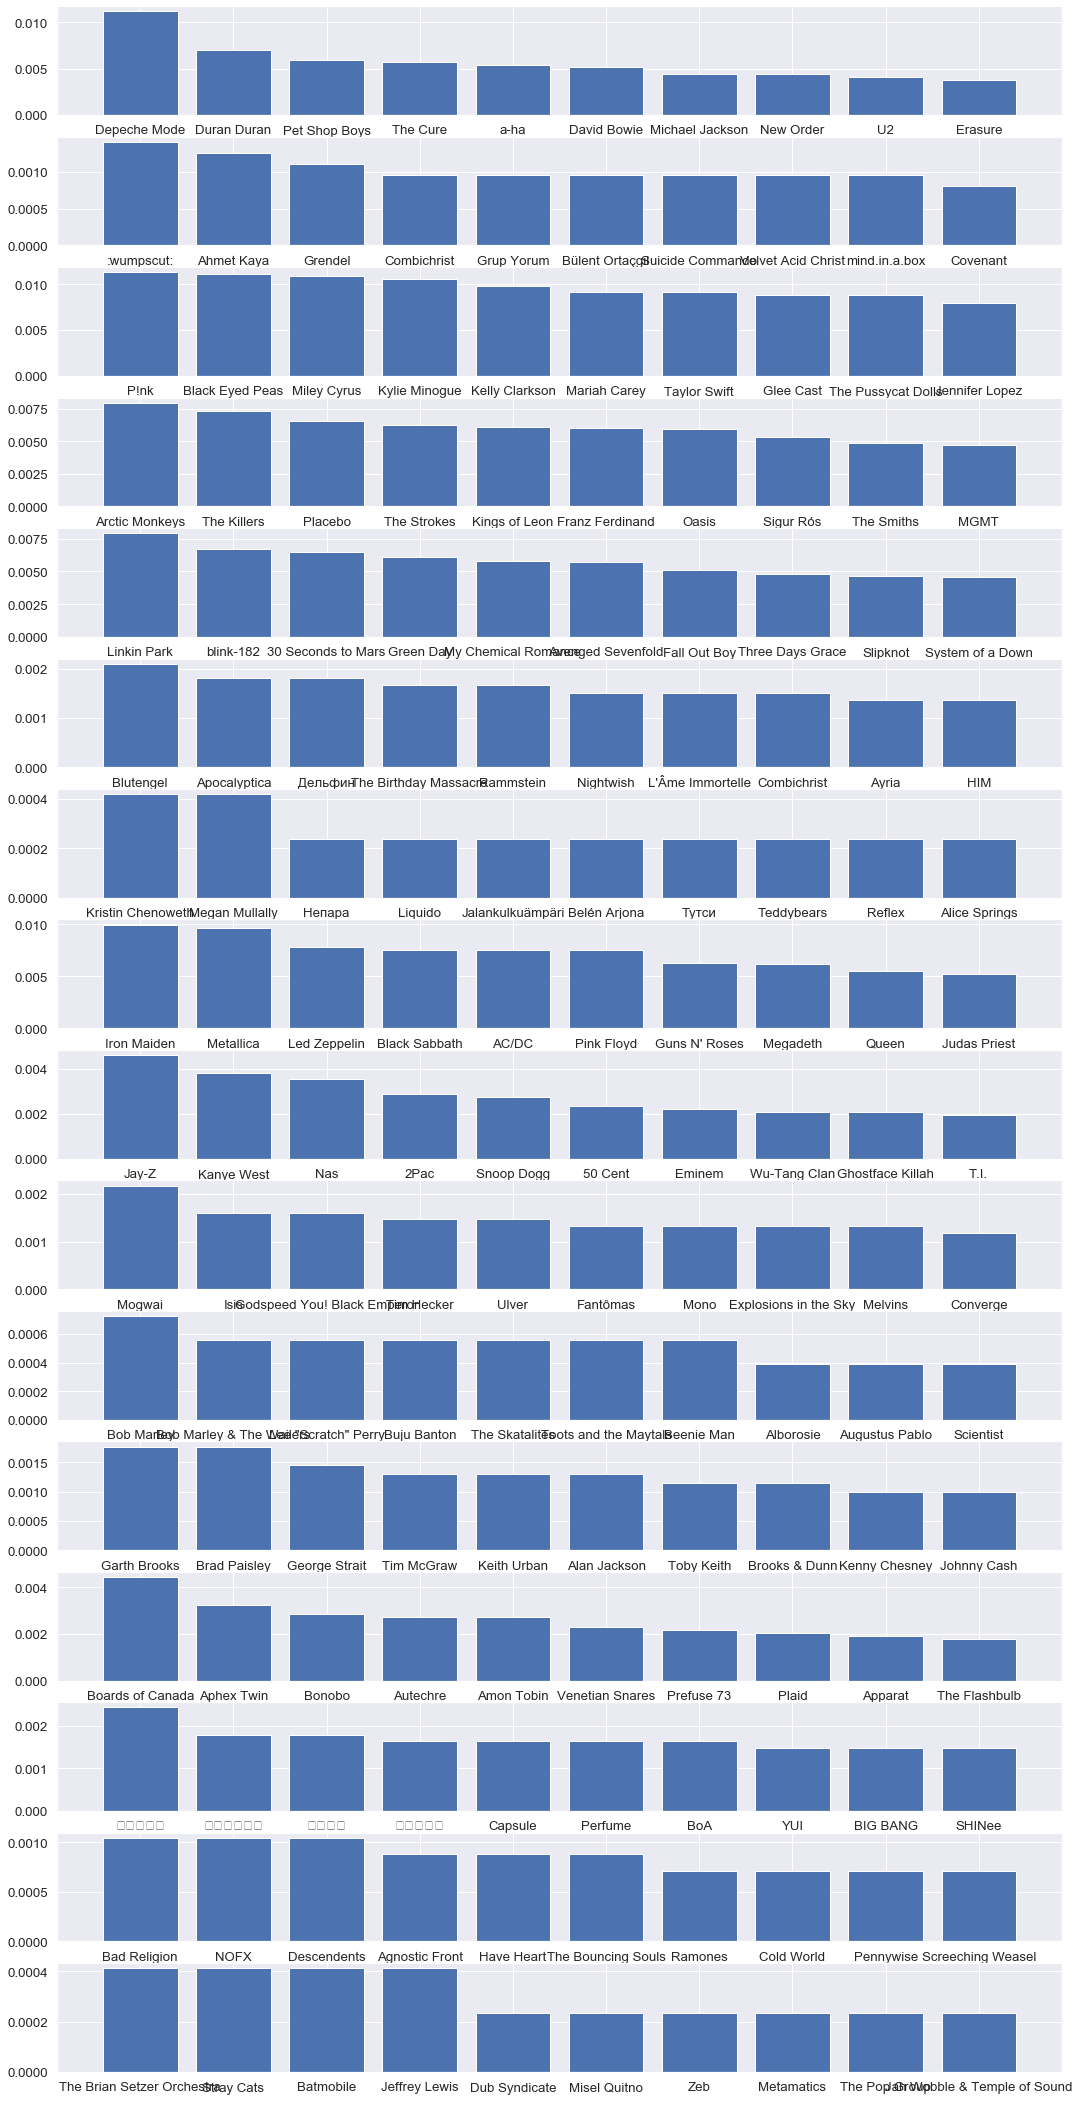

In [97]:
import seaborn as sns
sns.set_style("darkgrid")
              
fig, axs = plt.subplots(lda.k, figsize=(18,38))
for topic in range(lda.k):
    topics_rank = [topic[1] for topic in lda.get_topic_words(topic, 10)]
    topics_names = [topic[0] for topic in lda.get_topic_words(topic, 10)]
    axs[topic].bar(topics_names, topics_rank)

In [89]:
inferred_corpus, ll = lda.infer(m_corpus)

In [120]:
lda_doc = lda.make_doc(['Depeche Mode', 'Duran Duran' , 'Iron Maiden', 'Oasis'])

In [121]:
lda.infer([lda_doc])[0]

[array([6.9492662e-01, 1.1879036e-03, 1.8732913e-02, 2.1671273e-02,
        1.1233751e-02, 1.7960236e-03, 1.4351851e-04, 2.3892476e-01,
        1.7994149e-03, 1.6697175e-03, 1.8573594e-03, 1.1918677e-03,
        1.6133724e-03, 1.2404459e-03, 1.8135251e-03, 1.9747538e-04],
       dtype=float32)]

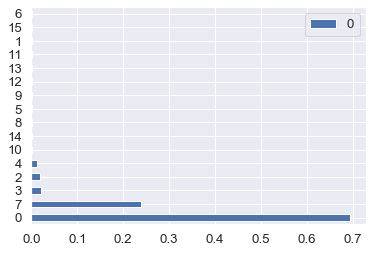

In [122]:
pd.DataFrame(lda.infer([lda_doc])[0][0]).sort_values(by=0, ascending=False).plot(kind='barh')

In [123]:
user_vector = lda.infer([lda_doc])[0][0]

In [124]:
users_topics = pd.DataFrame([doc.get_topic_dist() for doc in inferred_corpus] )

In [145]:
nearby_users_id = get_nearby_vectors_ids(user_vector, users_topics.values, n_items=500)
nearby_users_keys = [list(text_parts.keys())[id] for id in nearby_users_id]

In [146]:
top_artists = []
for user_key in nearby_users_keys:
    artists = text_parts[user_key]
    top_artists.extend(artists)

(unique, counts) = np.unique(top_artists, return_counts=True)
pop_cls = np.argsort(counts)[-15:]
pop_cls_keys = unique[pop_cls]
rec =  [get_artist_by_id(aid) for aid in pop_cls_keys] 
print_list(rec)

Muse
Duran Duran
Guns N' Roses
Nirvana
David Bowie
Black Sabbath
The Cure
AC/DC
Led Zeppelin
Queen
Iron Maiden
Metallica
Pink Floyd
Depeche Mode
The Beatles




In [147]:
nearby_users_vec = users_topics.values[nearby_users_id]

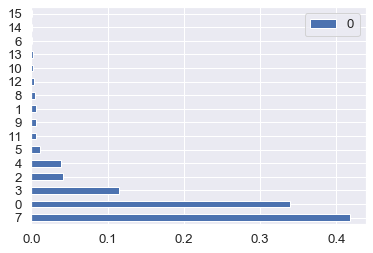

In [148]:
pd.DataFrame(np.mean(nearby_users_vec, axis=0)).sort_values(by=0, ascending=False).plot(kind='barh')

In [156]:
x = np.array([k for k in range(lda.k)])

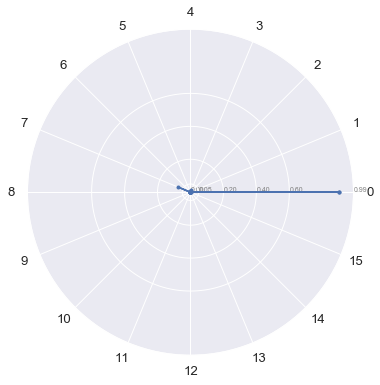

In [137]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# number of variable
categories=[k for k in range(lda.k)]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
#values=df.loc[0].drop('group').values.flatten().tolist()
#values += values[:1]
values = list(mean_users_vec)
values.append(values[0])

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(6,6))
plt.polar(angles, values, marker='.')
plt.fill(angles, values, alpha=0.3)
plt.xticks(angles[:-1], categories)
sns.set(font_scale=1.2)
ax = plt.gca()
ax.set_rlabel_position(0)
plt.yticks([0., 0.05, 0.2, 0.4, 0.6, 0.99], color='grey', size=7)
plt.ylim(0., 0.99)


plt.show()

In [149]:
np.linspace(0.0, 2 * np.pi, N, endpoint=False)

array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
       1.96349541, 2.35619449, 2.74889357, 3.14159265, 3.53429174,
       3.92699082, 4.3196899 , 4.71238898, 5.10508806, 5.49778714,
       5.89048623])

In [150]:
10 * np.random.rand(N)

array([4.49609298, 7.26480588, 1.30335214, 2.85949494, 1.19790129,
       7.19878698, 6.58252913, 0.62096135, 6.32102267, 2.46588911,
       3.29339705, 1.6156576 , 4.71001797, 2.22155844, 1.20377275,
       6.02233172])

In [1]:
pwd

'/Users/aagmon/work/TopicModelingAndEASE'